In [1]:
import scanpy as sc
import sys
sys.path.append("D:\Scunpair_Project\Diagonal-integration")
import SymAE
rna = sc.read_h5ad(r'D:\Scunpair_Project\Dataset\scRNA+scATAC 10x-Multiome-Pbmc10k\10x-Multiome-Pbmc10k-RNA.h5ad')
atac_gas = sc.read_h5ad(r'D:\Scunpair_Project\Dataset\scRNA+scATAC 10x-Multiome-Pbmc10k\10x-Multiome-Pbmc10k-FRAGS2RNA.h5ad')
atac_peak = sc.read_h5ad(r'D:\Scunpair_Project\Dataset\scRNA+scATAC 10x-Multiome-Pbmc10k\10x-Multiome-Pbmc10k-ATAC.h5ad')

In [2]:
rna.layers["counts"] = rna.X.copy()
atac_peak.layers["counts"] = atac_peak.X.copy()

# 取交集基因并对齐
cm_genes = sorted(list(set(atac_gas.var_names) & set(rna.var_names)))
rna = rna[:, cm_genes]
atac_gas = atac_gas[:, cm_genes]

# 计算高变基因
sc.pp.highly_variable_genes(rna, flavor='seurat_v3', n_top_genes=1000)
sc.pp.highly_variable_genes(atac_gas, flavor='seurat_v3', n_top_genes=1000)

# 取共同的高变基因
shared_genes = rna.var_names[rna.var.highly_variable | atac_gas.var.highly_variable]
shared_genes = list(shared_genes)

rna = rna[:,shared_genes].copy()
atac_gas = atac_gas[:,shared_genes].copy()

sc.pp.normalize_total(rna)
sc.pp.log1p(rna)

sc.pp.normalize_total(atac_gas)
sc.pp.log1p(atac_gas)

sc.pp.scale(rna, max_value=10)
sc.pp.scale(atac_gas, max_value=10)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:174: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:174: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [3]:
from scipy.spatial.distance import cdist
cost = cdist(rna.X, atac_gas.X, metric="correlation")

In [4]:
import anndata
from typing import Optional, Union
import scipy
import sklearn
import numpy as np
def lsi(
        adata: anndata.AnnData, n_components: int = 20,
        use_highly_variable: Optional[bool] = None, **kwargs
) -> None:
    r"""
    LSI analysis (following the Seurat v3 approach)
    """
    if use_highly_variable is None:
        use_highly_variable = "highly_variable" in adata.var
    adata_use = adata[:, adata.var["highly_variable"]] if use_highly_variable else adata
    X = tfidf(adata_use.X)
    X_norm = sklearn.preprocessing.Normalizer(norm="l1").fit_transform(X)
    X_norm = np.log1p(X_norm * 1e4)
    X_lsi = sklearn.utils.extmath.randomized_svd(X_norm, n_components, **kwargs)[0]
    X_lsi -= X_lsi.mean(axis=1, keepdims=True)
    X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)
    adata.obsm["X_lsi"] = X_lsi


def tfidf(X):
    r"""
    TF-IDF normalization (following the Seurat v3 approach)
    """
    idf = X.shape[0] / X.sum(axis=0)
    if scipy.sparse.issparse(X):
        tf = X.multiply(1 / X.sum(axis=1))
        return tf.multiply(idf)
    else:
        tf = X / X.sum(axis=1, keepdims=True)
        return tf * idf

In [5]:
sc.pp.pca(rna, n_comps=100)
lsi(atac_peak, n_components=100)

In [6]:
rna

AnnData object with n_obs × n_vars = 9631 × 1821
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [7]:
atac_peak

AnnData object with n_obs × n_vars = 9631 × 107194
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts'
    obsm: 'X_lsi'
    layers: 'counts'

In [8]:
model = SymAE.Model(rna, atac_peak, batch_size=500, 
                           training_steps=10001, seed=1234, input_key = ["X_pca", "X_lsi"], output_layer=["None", "None"], celltype_col='cell_type',source_col=None,
                            n_latent=16, lambdaRecon_input = 10.0, lambdaLA = 10.0, loss_type='MSE',
                            lambdaAlign = 1.0, lambdamGAN = 1.0, lambdabGAN = 0.0, lambdaGeo=1.0, lambdaCLIP=0.5, use_prior = False, cross_dist=cost)

d:\Scunpair_Project\Diagonal-integration\SymAE\dataloader.py:55: UserWarning: None not found in adata.layers; output=None.
  warnings.warn(f"{output_layer} not found in adata.layers; output=None.")


In [9]:
model.train_integration()

Training started at: Mon Nov 10 00:04:40 2025
Step 0 | loss_AE_input: 38.8754 | loss_LA: 2.5223 | loss_Align: 0.2540 | loss_Geo: 0.2138 | loss_CLIP: 0.0000 | loss_mGAN vs loss_mDis: -1.1100 vs 1.1943 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 1000 | loss_AE_input: 14.4547 | loss_LA: 0.1281 | loss_Align: 0.1930 | loss_Geo: 0.1086 | loss_CLIP: 0.0000 | loss_mGAN vs loss_mDis: -1.3566 vs 1.3763 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 2000 | loss_AE_input: 13.3766 | loss_LA: 0.0886 | loss_Align: 0.1284 | loss_Geo: 0.0711 | loss_CLIP: 0.0000 | loss_mGAN vs loss_mDis: -1.3185 vs 1.3380 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 3000 | loss_AE_input: 12.9675 | loss_LA: 0.0762 | loss_Align: 0.0970 | loss_Geo: 0.0551 | loss_CLIP: 0.0000 | loss_mGAN vs loss_mDis: -1.2028 vs 1.2192 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 4000 | loss_AE_input: 13.0192 | loss_LA: 0.0771 | loss_Align: 0.0926 | loss_Geo: 0.0572 | loss_CLIP: 0.0000 | loss_mGAN vs loss_mDis: -1.1357 vs 1.1

In [29]:
model.train_imputation()

Training started at: Mon Nov 10 00:00:29 2025


KeyError: 'output'

In [10]:
model.get_latent_representation()

Started at: Mon Nov 10 00:10:30 2025
Completed at: Mon Nov 10 00:10:30 2025
Total time: 0.10 seconds
Processed 19262 samples
Latent space shape: (19262, 16)


In [11]:
import anndata as ad
import pandas as pd
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([rna.obs, atac_gas.obs])
adata_integrated.obs['modality'] = ['RNA'] * rna.shape[0] + ['ATAC'] * atac_gas.shape[0]

In [12]:
sc.pp.neighbors(adata_integrated)
sc.tl.umap(adata_integrated, min_dist=0.3)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


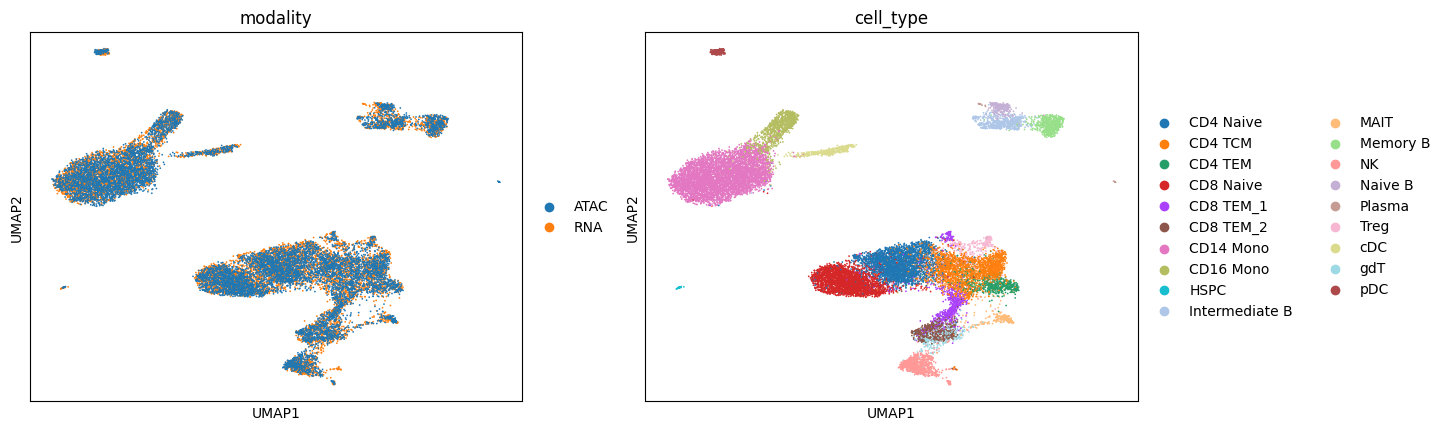

In [13]:
sc.pl.umap(adata_integrated, color=['modality','cell_type'])

In [14]:
model.get_imputation()

Started at: Mon Nov 10 01:24:30 2025
Completed at: Mon Nov 10 01:24:30 2025
Total time: 0.10 seconds
Processed 19262 samples


In [ ]:
rna.layers['counts']

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1184283 stored elements and shape (9631, 1821)>

In [ ]:
imputed_BtoA = model.imputed_BtoA
imputed_df_BtoA = pd.DataFrame(imputed_BtoA, index=rna.obs.index, columns=rna.var_names)

In [ ]:
sc.pp.pca(rna, n_comps=100)

In [ ]:
sc.pp.neighbors(rna)
sc.tl.umap(rna)

In [ ]:
rna.X = rna.layers["counts"]

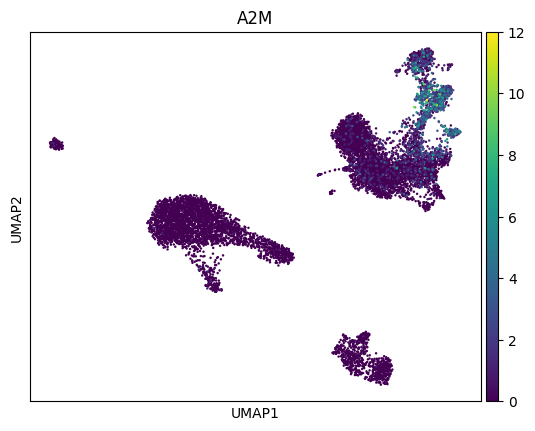

In [ ]:
sc.pl.umap(rna, color='A2M')

In [ ]:
rna.obs['imputed_A2M'] = imputed_df_BtoA['A2M']

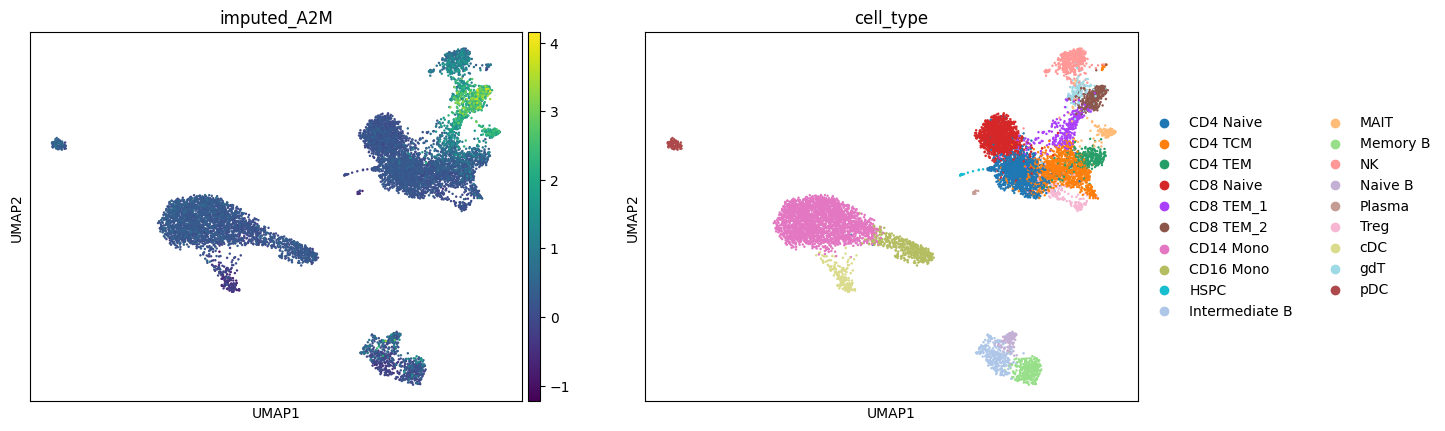

In [ ]:
sc.pl.umap(rna, color=['imputed_A2M', 'cell_type'])

In [ ]:
rna.layers['counts'].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(9631, 1821), dtype=float32)